# Sample notebook for reading the output of quail

Use this notebook after running 

```
python3 quail conduit.py
```

in this folder (`scenarios/startup_example`).

If `quail` cannot be found, provide the absolute path to quail (`<your-installation-location>/quail_volcano/src/quail`) or add quail to your `$PATH` and `$PYTHONPATH`. For more information, see the readme in this folder or installation instructions on the github landing page. On some installations, use `python` instead of `python3`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Specify path where .pkl files are located
target_dir = r"C:\code\quail_volcano\scenarios\simple_1D_test"
# Specify path for Quail source code
source_dir = r"C:\code\quail_volcano\src"
# Change to working directory
os.chdir(target_dir)

In [2]:
# Import quail modules
os.chdir(source_dir)

import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp  
from multidomain import Domain, Observer

os.chdir(target_dir)

Loads a .pkl file, with index specified by `file_idx`, and plots the new state variable. For other variables see the subsequent code box.

Plot of new state variable pDensityX (should be all zeros since we haven't set anything special)


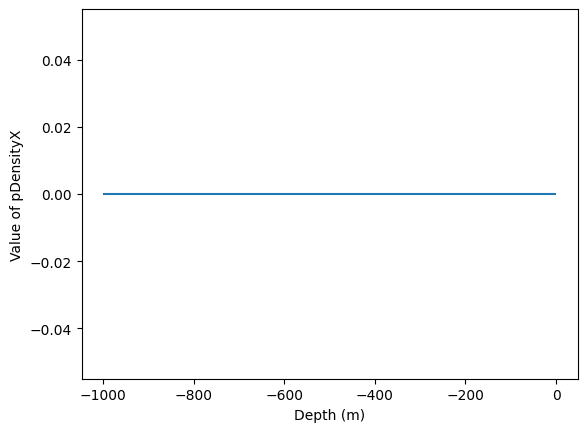

In [7]:
# Load a solver and interact
file_idx = 25
solver = readwritedatafiles.read_data_file(f"test_output_{file_idx}.pkl")

# solver.state_coeffs holds the solution values at the nodes of each element
# The shape of state_coeffs is
#   [ne, nb, ns]
# where ne is the number of elements, nb is the number of nodes (also finite
# element basis dimension) in each element, and ns is the number of states

# Here we access the newly implemented state variable by giving the name "pDensityX" to
# solver.physics.get_state_index; alternatively, we can directly use index 8
pDensityX = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityX")]

# Time in the current .pkl file
t = solver.time

# Get the position of of each nodal points (location corresponding to each entry of pDensityX)
nodal_pts = solver.basis.get_nodes(solver.order)
# Allocate [ne] x [nb, ndims]
x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
for elem_ID in range(solver.mesh.num_elems):
  # Fill coordinates in physical space
  x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)

# Due to the shape, plotting requires unraveling the states
plt.plot(x.ravel(), pDensityX.ravel())
plt.xlabel("Depth (m)")
plt.ylabel("Value of pDensityX")
print("Plot of new state variable pDensityX (should be all zeros since we haven't set anything special)")

Example of manipulating other variables

Temperature (and later pressure) are not uniform because with the gravity source, the initially uniform fluid starts to settle and interacts with the top and bottom walls (boundary conditions).


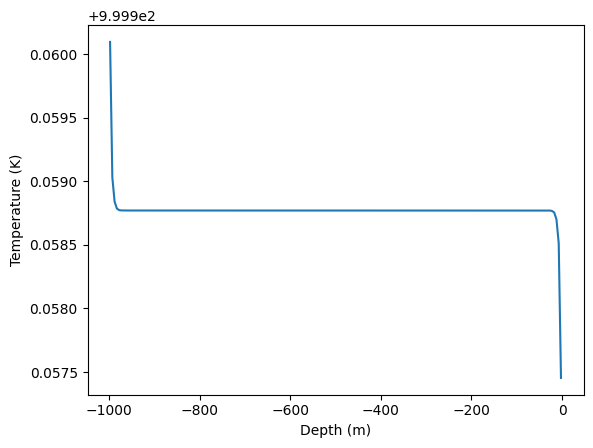

In [8]:
# Partial density of air (i.e. mass of air per unit total volume)
pDensityA = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityA")]
# Partial density of water vapour (exsolved water)jeff 
pDensityWv = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityWv")]
# Partial density of magma (melt + dissolved water + crystals)
pDensityM = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityM")]
# Momentum per unit volume
x_momentum = solver.state_coeffs[:, :, solver.physics.get_state_index("XMomentum")]
# Total energy (including kinetic) per unit volume
energy_density = solver.state_coeffs[:, :, solver.physics.get_state_index("Energy")]
# Partial density of total water (exsolved water + dissolved water)
# Note that dissolved water is Wt - Wv
pDensityWt = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityWt")]
# Partial density of crystals
pDensityC = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityC")]

# For additional variables:
flag_non_physical = True
p = solver.physics.compute_additional_variable(
  "Pressure", solver.state_coeffs, flag_non_physical)
T = solver.physics.compute_additional_variable(
  "Temperature", solver.state_coeffs, flag_non_physical)
soundspeed = solver.physics.compute_additional_variable(
  "SoundSpeed", solver.state_coeffs, flag_non_physical)
# For more variables, consult
#   physics/multiphasevpT/multiphasevpT.py > MultiphasevpT > AdditionalVariables

# Time
t = solver.time
# To get nodal points (x where each state is evaluated):
# Get reference element nodes
nodal_pts = solver.basis.get_nodes(solver.order)
# Allocate [ne] x [nb, ndims]
x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
for elem_ID in range(solver.mesh.num_elems):
  # Fill coordinates in physical space
  x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)

# Due to the shape, plotting requires unraveling the states
plt.plot(x.ravel(), T.ravel())
plt.xlabel("Depth (m)")
plt.ylabel("Temperature (K)")
print("Temperature (and later pressure) are not uniform because with the gravity source, the initially uniform fluid starts to settle and interacts with the top and bottom walls (boundary conditions).")

Text(0, 0.5, 'Pressure (MPa)')

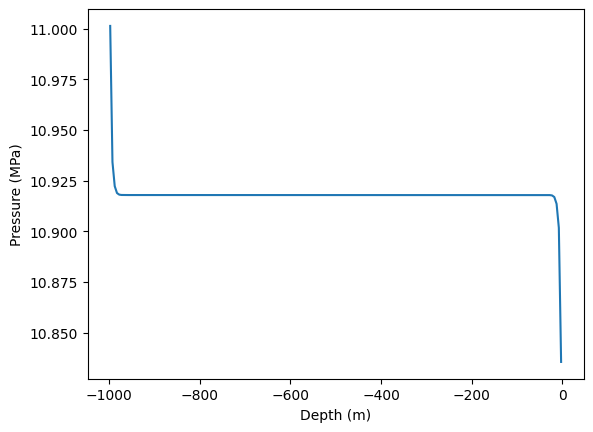

In [9]:
# Due to the shape, plotting requires unraveling the states
plt.plot(x.ravel(), p.ravel() / 1e6)
plt.xlabel("Depth (m)")
plt.ylabel("Pressure (MPa)")